In [3]:
#matplotlib inline
from __future__ import division
import numpy as np
from numpy.random import rand
from numpy import linalg as LA
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as mlines
import math
import sys
import os
from random import shuffle
from random import gauss
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.optimize import fmin
from scipy.optimize import fsolve
from scipy import interpolate
from scipy.optimize import curve_fit
import scipy.optimize as opt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from pylab import polyfit 
import matplotlib.ticker as ticker
from matplotlib import gridspec
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
from scipy.optimize import differential_evolution
import warnings
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
%matplotlib inline


def fit_func_cv(x ,a ,b, c, d, e):
        return  np.exp(a)*x + b*np.absolute(x - d)**(-c) + np.exp(e)

    
def fit_func_cv_fix(x, b, d):
    return  b*np.absolute(x - d)**(-1/3)

######
#-----------------------------------------------------------------------------------------------------------------------
#######
#parameters of the code
######
#-----------------------------------------------------------------------------------------------------------------------
######

j2 = 1.0
j6 = 1.0
Kc = 0.0
lambda3 = 2.1
q_Q = 1
N_list = [60, 80, 100, 120, 140, 160, 180, 200, 300, 380]
N_og = [10, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 300, 380]

#N_fit_cv = 200
N_fit_cv = 300
####
#code
###

cv_ind = 1


data = np.load('Delta1_data.npy',allow_pickle=True)

#create a mix of all of them:
flat_data = []
flat_error = []
flat_temp = []

Tmin_l = []
Tmax_l = []
for i in range(len(N_list)):
    i_og = i + 3
    flat_data.extend((N_list[i]**2)*data[i_og][2*cv_ind + 1])
    flat_error.extend((N_list[i])*data[i_og][2*cv_ind + 2])
    flat_temp.extend(data[i_og][0])
    
    Tmin_l.append(np.min(data[i_og][0]))
    Tmax_l.append(np.max(data[i_og][0]))

    
    
flat_data = np.array(flat_data)
flat_error =  np.array(flat_error)
flat_temp =  np.array(flat_temp)

all_together = np.array([flat_temp, flat_data, flat_error])
all_together = np.transpose(all_together)
all_together_sorted = all_together[all_together[:,0].argsort()]

#print(all_together_sorted)

#create duplicates list
seen = set()
uniq = []
for x in list(all_together_sorted[:,0]):
    if x not in seen:
        uniq.append(x)
        seen.add(x)
        
sorted_and_filter_temp = np.sort(np.array(list(seen)))

values_avg = np.zeros(len(sorted_and_filter_temp))
values_err = np.zeros(len(sorted_and_filter_temp))
temps_all = all_together_sorted[:,0]
j=0
n = 1
for i in range(len(sorted_and_filter_temp)):
    indices = np.argwhere(temps_all == sorted_and_filter_temp[i])
    values_avg[i] = np.mean((all_together_sorted[:,1])[indices])
    values_err[i] = np.mean((all_together_sorted[:,2])[indices])
    
    
    


###########
#fit for a specific Cv
jind = N_og.index(N_fit_cv)

fit_all = False
if fit_all:
    data_fit = values_avg
    data_err = values_err
    x_range_fit = sorted_and_filter_temp
else:
    data_fit =  (N_og[jind]**2)*data[jind][2*cv_ind + 1]
    data_err = (N_og[jind])*data[jind][2*cv_ind + 1]
    x_range_fit = data[jind][0]
    


#popt2, pcov2 = curve_fit(fit_func_cv, x_range_fit, data_fit, sigma = data_err,\
# absolute_sigma = True, p0 = [0.5, 0.4, 1.2], bounds = ([0, 0.01, 0.1], [10, 1.0, 2.0]))
popt2, pcov2 = curve_fit(fit_func_cv, x_range_fit, data_fit, sigma = data_err, absolute_sigma = True, p0 = [0.0, 0.5, 0.4, 1.201, 0.0])
#popt2, pcov2 = curve_fit(fit_func_cv_fix, x_range_fit, data_fit, sigma = data_err, absolute_sigma = True, p0 = [0.5, 1.201])

print('fit vals')
print(popt2)
print('errors')
print(np.sqrt(np.diag(pcov2)))

#y_fit = fit_func_cv_fix(x_range_fit, *popt2)
y_fit = fit_func_cv(x_range_fit, *popt2)
y = data_fit
# residual sum of squares
ss_res = np.sum((y - y_fit) ** 2)
# total sum of squares
ss_tot = np.sum((y - np.mean(y)) ** 2)
# r-squared
r2 = 1 - (ss_res / ss_tot)

print()
print('R2 fit value')
print(r2)

fit vals
[ -3.46157894   1.46940079   0.37552336   1.20242355 -21.6848343 ]
errors
[3.30400935e-01 8.27169152e-03 1.02620677e-03 1.58902553e-05
 1.72156545e+06]

R2 fit value
0.9472268078177113


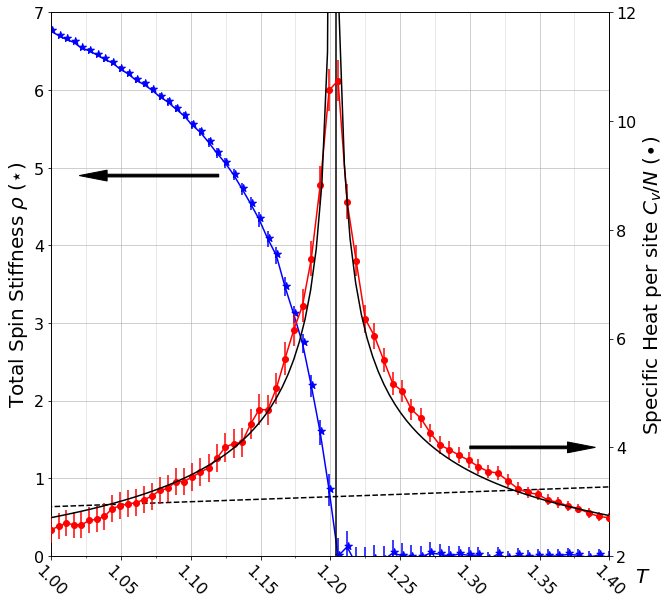

In [5]:
######
#- initialize plot number one
######

N_toplot = 300

cNorm  = colors.Normalize(vmin=0, vmax=1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap='brg_r')
colors_size = [scalarMap.to_rgba(i/(len(N_list)-1)) for i in range(len(N_list))]
fit_color = 'black'

Tmin = np.min(Tmin_l)
Tmax = np.max(Tmax_l)
#major_ticks = np.linspace(Tmin, Tmax, int((Tmax - Tmin)/0.1)+1)                                              
#minor_ticks = np.linspace(Tmin, Tmax, int((Tmax - Tmin)/0.05)+1) 
major_ticks = np.arange(Tmin, Tmax + 0.01, 0.05)
minor_ticks = np.arange(Tmin, Tmax + 0.01, 0.05/2)


fig2, ax2 = plt.subplots(figsize = (10,10))
ax2.set_ylabel(r'Total Spin Stiffness $\rho$ ($\star$)', color='black', fontsize = 20)
for i in range(len(N_list)):
    if N_list[i] == N_toplot:
        i_og = 3 + i
        x_range = data[i_og][0]
        data_list = data[i_og][2*12 + 1]
        data_err = data[i_og][2*12 + 2]
        ax2.errorbar(x_range, data_list, yerr = (N_list[i]**(1/4))*data_err, \
              linestyle = '-', marker = r"$\star$", color='blue', markersize = 10)
ax2.tick_params(axis='y', labelcolor='black', labelsize = 16)
ax2.plot([0, Tmax], [2*0/np.pi, 2*Tmax/np.pi], color = 'black', linestyle = '--')
ax2.set_ylim([0,7])
ax2.set_xlim([1.0, 1.4])


ax2.set_xticks(major_ticks)     
tick_print = []
for elem in major_ticks:
    tick_print.append('{:.2f}'.format(elem))
ax2.set_xticks(minor_ticks, minor=True)  
ax2.set_xticklabels(tick_print, rotation=315, fontsize = 16) 
ax2.set_xlabel(r'$T$', fontsize = 20)
ax2.xaxis.set_label_coords(1.06, -0.02)
ax2.grid(which='minor', alpha=0.35)                                                
ax2.grid(which='major', alpha=0.75)



ax0 = ax2.twinx()  # instantiate a second axes that shares the same x-axis
# log scale for axis Y of the first subplot
#fit plot appears on top
#ax0.plot(x_range_fit, fit_func_cv(x_range_fit, *popt2), linestyle = '--', color = fit_color, zorder = 100)
x_range_fit_p = np.linspace(Tmin, Tmax, 100)
y_fit_p = fit_func_cv(x_range_fit_p, *popt2)
ax0.plot(x_range_fit_p, y_fit_p, linestyle = '-', color = fit_color, zorder = 100)
#ax0.errorbar(sorted_and_filter_temp,values_avg, yerr = values_err, color = 'black', zorder = 200)
tcvmax = []
#cv plots
for i in range(len(N_list)):
    if N_list[i] == N_toplot:
        i_og = 3 + i
        x_range = data[i_og][0]
        data_list = data[i_og][2*1 + 1]
        data_err = data[i_og][2*1 + 2]
        ax0.errorbar(x_range, (N_list[i]**2)*data_list, yerr = (N_list[i])*data_err, \
                    fmt ='-'+ 'o', color='red', zorder = 1 + i)

        tcvmax.append(x_range[np.argmax((N_list[i]**2)*data_list)])
ax0.set_ylabel(r'Specific Heat per site $C_v/N$ ($\bullet$)', color='black', fontsize = 20)
ax0.tick_params(axis='y', labelcolor='black', labelsize = 16)
ax0.set_xlim([1.0, 1.4])
ax0.set_ylim([2,12])
ax0.plot([1.2038, 1.2038], ax0.get_ylim(), color = 'black')

patches_lg = []
for i in range(len(N_list)):
    if N_list[i] == N_toplot:
        patches_lg.append(patches.Patch(color=colors_size[i], label='L='+str(int(N_list[i]))))
patches_lg.append(patches.Patch(color= fit_color, label=r'fit $t^{-\alpha}$'))
#ax0.legend(handles=patches_lg, bbox_to_anchor=(0.7,0.3,0.25,0.2), loc="lower left",
#                mode="expand", borderaxespad=0, ncol=1,fontsize = 20)


ax0.arrow(1.12, 9.0, -0.1, 0.0, length_includes_head=True, width = 0.05,
          head_width=0.2, head_length=0.02, color = 'black')

ax0.arrow(1.3, 4.0, 0.09, 0.0, length_includes_head=True, width = 0.05,
          head_width=0.2, head_length=0.02, color = 'black')





plt.savefig('./fig-cvrhoDelta10-noinset'.format(j2)+ '.png', format='png', dpi = 100,bbox_inches='tight')
plt.show()


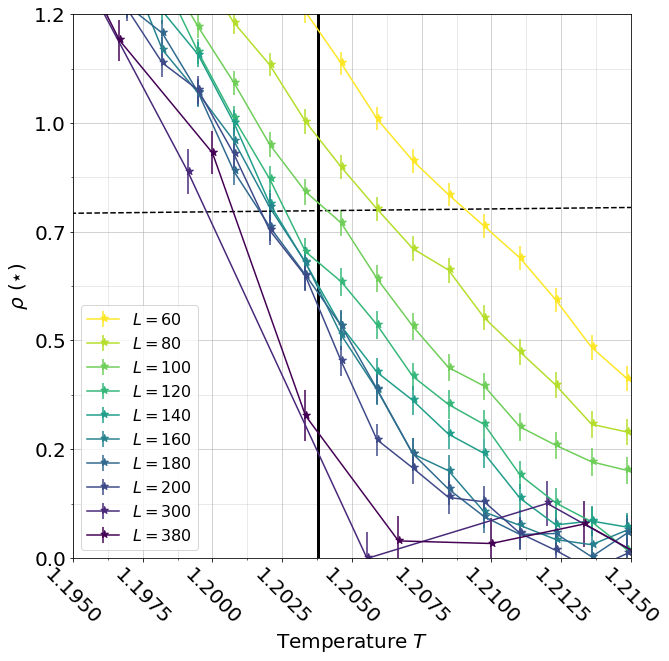

In [8]:
##################
#
#inset only
#
#################

######
#- initialize plot number one
######

cNorm  = colors.Normalize(vmin=0, vmax=1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap='viridis_r')
colors_size = [scalarMap.to_rgba(i/(len(N_list)-1)) for i in range(len(N_list))]
fit_color = 'black'

Tmin = np.min(Tmin_l)
Tmax = np.max(Tmax_l)
#major_ticks = np.linspace(Tmin, Tmax, int((Tmax - Tmin)/0.1)+1)                                              
#minor_ticks = np.linspace(Tmin, Tmax, int((Tmax - Tmin)/0.05)+1) 
major_ticks = np.arange(Tmin, Tmax + 0.01, 0.05)
minor_ticks = np.arange(Tmin, Tmax + 0.01, 0.05/2)


fig2, ax3 = plt.subplots(figsize = (10,10))

ax3.set_ylabel(r'$\rho$ ($\star$)', color='black', fontsize = 20)
ax3.set_xlabel(r'Temperature $T$', color='black', fontsize = 20)
for i in range(len(N_list)):
    i_og = 3 + i
    x_range = data[i_og][0]
    data_list = data[i_og][2*12 + 1]
    data_err = data[i_og][2*12 + 2]
    ax3.errorbar(x_range, data_list, yerr = data_err, \
          linestyle = '-', marker = r"$\star$", color=colors_size[i], markersize = 10, label = r'$L = $' + str(int(N_list[i])))

ax3.plot([0, Tmax], [2*0/np.pi, 2*Tmax/np.pi], color = 'black', linestyle = '--')
Tmin2 = 1.195
Tmax2 = 1.215
ax3.plot([1.2038, 1.2038], [0,1.2], color = 'black',linewidth = 3.0)
ax3.set_ylim([0,1.2])
ax3.set_xlim([Tmin2, Tmax2])



#major_ticks = np.linspace(Tmin2, Tmax2, 5) 
#minor_ticks = np.linspace(Tmin2, Tmax2, 9) 
major_ticks = np.arange(Tmin2, Tmax2+0.0001, 0.0025) 
minor_ticks = np.arange(Tmin2, Tmax2+0.0001, 0.0025/2) 
ax3.set_xticks(major_ticks)     
tick_print = []
for elem in major_ticks:
    tick_print.append('{:.4f}'.format(elem))
ax3.set_xticks(minor_ticks, minor=True)  
ax3.set_xticklabels(tick_print, rotation=315, fontsize = 20) 

#y ticks
yticksval = np.linspace(0, 1.2, 6)
yticksvalmin = np.linspace(0, 1.2, 11)

ytick_print = []
for elem in yticksval:
    ytick_print.append('{:.1f}'.format(elem))
    
ax3.set_yticks(yticksval)
ax3.set_yticks(yticksvalmin, minor=True)  
ax3.set_yticklabels(ytick_print, fontsize = 20) 

#ax1.set_yticklabels(ax1.get_yticks(), fontsize = 20)
#ax3.xaxis.set_label_coords(1.08, 0.01)
ax3.grid(which='minor', alpha=0.35)                                                
ax3.grid(which='major', alpha=0.7)

plt.legend(fontsize = 16)


plt.savefig('./fig-cvrhoDelta10-zoomstiff'.format(j2)+ '.png', format='png', dpi = 100,bbox_inches='tight')
plt.show()